# Quadratic Based

--- Starting Meta-Training of Learned Optimizer ---
Epoch 0, Avg Final Loss: 49.335138
Epoch 100, Avg Final Loss: 3.874504
Epoch 200, Avg Final Loss: 3.291681
Epoch 300, Avg Final Loss: 3.344019
Epoch 400, Avg Final Loss: 2.575589
Epoch 500, Avg Final Loss: 3.270784
Epoch 600, Avg Final Loss: 3.107675
Epoch 700, Avg Final Loss: 2.597355
Epoch 800, Avg Final Loss: 3.202746
Epoch 900, Avg Final Loss: 2.965013
--- Meta-Training Finished ---

--- Starting Evaluation ---
--- Evaluation Finished ---


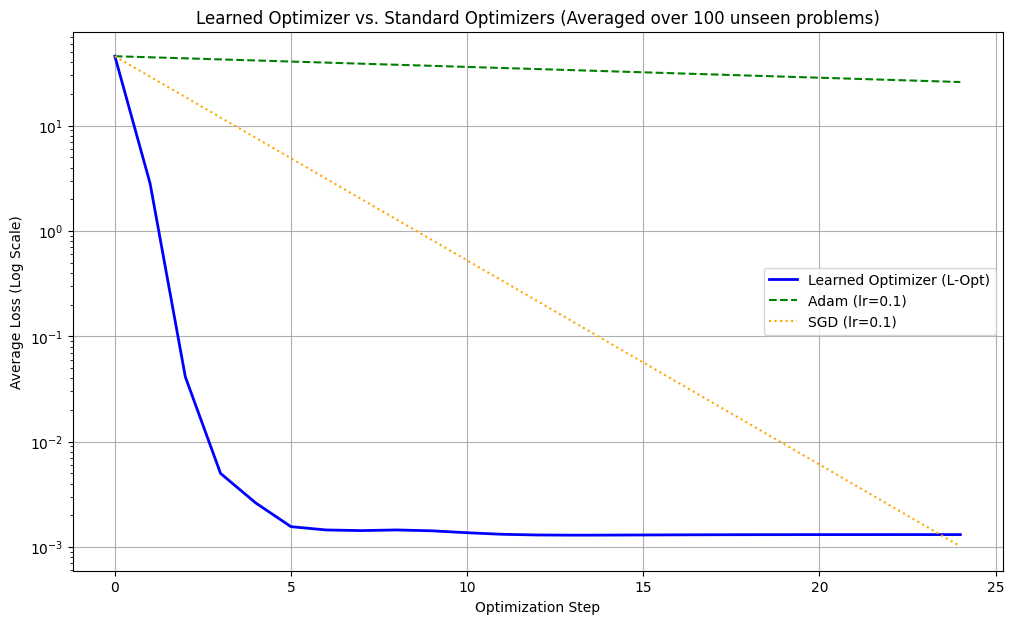

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


# We'll use f(x) = (x - target)^2
# The family is all functions of this form, where target can vary.

def f(x, target):
    """Batched function: f(x) = (x - target)^2"""
    return (x - target)**2

def grad_f(x, target):
    """Batched gradient: d/dx f(x) = 2(x - target)"""
    return 2 * (x - target)

# RNN Based Optimizer
class LearnedOptimizer(nn.Module):
    def __init__(self, input_size=1, hidden_size=20, output_size=1):
        super(LearnedOptimizer, self).__init__()
        # Use an LSTM to keep track of optimization history (can be thought lf as momentum)
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, grad, hidden_state):
        # Input is the current gradient
        # Reshape grad for LSTM: (batch, seq_len, features)
        grad_reshaped = grad.unsqueeze(1)
        # Process with LSTM
        out, new_hidden_state = self.lstm(grad_reshaped, hidden_state)
        # Output is the update step (delta_x)
        update_step = self.output_layer(out.squeeze(1))

        return update_step, new_hidden_state

meta_epochs = 1000
unroll_steps = 20
meta_lr = 0.01
batch_size = 128
# Instantiate the optimizer network and its meta-optimizer
lopt = LearnedOptimizer()
meta_optimizer = optim.Adam(lopt.parameters(), lr=meta_lr)

print("--- Starting Meta-Training of Learned Optimizer ---")
lopt.train()

for epoch in range(meta_epochs):

    # Initialize a batch of problems to solve
    targets = torch.randn(batch_size, 1) * 5.0
    x = torch.randn(batch_size, 1) * 5.0

    # Initialize hidden state for the LSTM
    hidden = (torch.zeros(1, batch_size, 20),
              torch.zeros(1, batch_size, 20))

    total_loss_for_meta_update = 0

    for t in range(unroll_steps):
        # Calculate loss and gradient of the problem
        loss = f(x, targets)
        grad = grad_f(x, targets)
        # Find total loss for the meta-update
        total_loss_for_meta_update += loss.mean()
        # Detach grad to prevent backprop through the problem
        update_step, hidden = lopt(grad.detach(), hidden)
        x = x + update_step # Apply the update

    # --- Meta-Update Step ---
    meta_optimizer.zero_grad()
    total_loss_for_meta_update.backward()
    meta_optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Avg Final Loss: {total_loss_for_meta_update.item() / unroll_steps:.6f}")

print("--- Meta-Training Finished ---")

print("\n--- Starting Evaluation ---")

lopt.eval()

eval_steps = 25
num_eval_problems = 100
sgd_lr = 0.1
adam_lr = 0.1

lopt_loss_history = np.zeros((num_eval_problems, eval_steps))
sgd_loss_history = np.zeros((num_eval_problems, eval_steps))
adam_loss_history = np.zeros((num_eval_problems, eval_steps))

for i in range(num_eval_problems):
    target = torch.randn(1, 1) * 5.0
    start_x = torch.randn(1, 1) * 5.0 # Creating test problems

    with torch.no_grad():
        x_lopt = start_x.clone()
        h_lopt = (torch.zeros(1, 1, 20), torch.zeros(1, 1, 20))
        for t in range(eval_steps):
            loss = f(x_lopt, target)
            lopt_loss_history[i, t] = loss.item()
            grad = grad_f(x_lopt, target)
            update, h_lopt = lopt(grad, h_lopt)
            x_lopt = x_lopt + update

    x_sgd = start_x.clone()
    for t in range(eval_steps):
        loss = f(x_sgd, target)
        sgd_loss_history[i, t] = loss.item()
        grad = grad_f(x_sgd, target)
        x_sgd = x_sgd - sgd_lr * grad # Standard SGD update rule

    x_adam = nn.Parameter(start_x.clone())
    adam_optimizer = optim.Adam([x_adam], lr=adam_lr)
    for t in range(eval_steps):
        adam_optimizer.zero_grad()
        loss = f(x_adam, target)
        adam_loss_history[i, t] = loss.item()
        loss.backward() # Calculate gradient
        adam_optimizer.step() # Apply Adam's update rule

print("--- Evaluation Finished ---")
# Calculate the average loss at each step across all test problems
avg_lopt_loss = np.mean(lopt_loss_history, axis=0)
avg_sgd_loss = np.mean(sgd_loss_history, axis=0)
avg_adam_loss = np.mean(adam_loss_history, axis=0)

plt.figure(figsize=(12, 7))
plt.plot(avg_lopt_loss, label='Learned Optimizer (L-Opt)', color='blue', linewidth=2)
plt.plot(avg_adam_loss, label=f'Adam (lr={adam_lr})', color='green', linestyle='--')
plt.plot(avg_sgd_loss, label=f'SGD (lr={sgd_lr})', color='orange', linestyle=':')

plt.title('Learned Optimizer vs. Standard Optimizers (Averaged over 100 unseen problems)')
plt.xlabel('Optimization Step')
plt.ylabel('Average Loss (Log Scale)')
plt.yscale('log') # Log scale is essential for optimizer comparison
plt.legend()
plt.grid(True)
plt.show()

# Rastrigin Function

--- Starting Meta-Training of Learned Optimizer (2D Rastrigin) ---
Epoch 0, Avg Final Loss: 145.270322
Epoch 100, Avg Final Loss: 104.724893
Epoch 200, Avg Final Loss: 115.094551
Epoch 300, Avg Final Loss: 110.474326
Epoch 400, Avg Final Loss: 103.618770
Epoch 500, Avg Final Loss: 110.217930
Epoch 600, Avg Final Loss: 99.395371
Epoch 700, Avg Final Loss: 102.046514
Epoch 800, Avg Final Loss: 88.034971
Epoch 900, Avg Final Loss: 97.129189
Epoch 1000, Avg Final Loss: 89.293867
Epoch 1100, Avg Final Loss: 97.877539
Epoch 1200, Avg Final Loss: 110.531719
Epoch 1300, Avg Final Loss: 107.939990
Epoch 1400, Avg Final Loss: 98.063447
Epoch 1500, Avg Final Loss: 94.375342
Epoch 1600, Avg Final Loss: 99.469600
Epoch 1700, Avg Final Loss: 105.121680
Epoch 1800, Avg Final Loss: 102.689053
Epoch 1900, Avg Final Loss: 101.980127
--- Meta-Training Finished ---

--- Starting Evaluation (2D Rastrigin) ---
--- Evaluation Finished ---


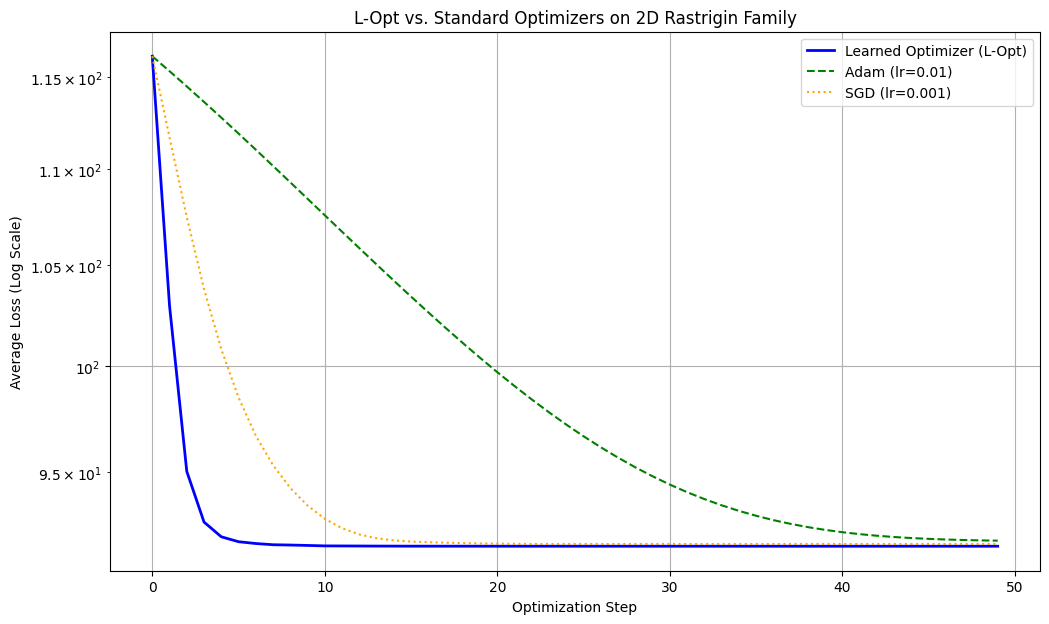

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Hyperparameters
IO_DIMENSIONS = 2  
HIDDEN_SIZE = 20
meta_epochs = 2000 
unroll_steps = 25  
meta_lr = 0.001    
batch_size = 128


def f(x, target):
    """
    Batched 2D Rastrigin function.
    x: (batch_size, 2) tensor of (x, y) positions
    target: (batch_size, 2) tensor of (tx, ty) minimums
    """
    n = IO_DIMENSIONS
    x_shifted = x - target
    return (10 * n) + torch.sum(x_shifted**2 - 10 * torch.cos(2 * torch.pi * x_shifted), dim=1, keepdim=True)

def grad_f(x, target):
    """
    Batched 2D gradient of Rastrigin function.
    x: (batch_size, 2) tensor
    target: (batch_size, 2) tensor
    """
    x_shifted = x - target
    return 2 * x_shifted + 20 * torch.pi * torch.sin(2 * torch.pi * x_shifted)

# RNN Based Learned Optimizer
class LearnedOptimizer(nn.Module):
    def __init__(self, input_size=IO_DIMENSIONS, hidden_size=HIDDEN_SIZE, output_size=IO_DIMENSIONS): # <-- CHANGED
        super(LearnedOptimizer, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, grad, hidden_state):
        grad_reshaped = grad.unsqueeze(1)
        out, new_hidden_state = self.lstm(grad_reshaped, hidden_state)
        update_step = self.output_layer(out.squeeze(1))
        return update_step, new_hidden_state

# Meta Training

lopt = LearnedOptimizer()
meta_optimizer = optim.Adam(lopt.parameters(), lr=meta_lr)

print("--- Starting Meta-Training of Learned Optimizer (2D Rastrigin) ---")
lopt.train()

for epoch in range(meta_epochs):
    # Initialize a batch of problems to solve
    targets = torch.randn(batch_size, IO_DIMENSIONS) * 5.0 # Some random targets
    x = torch.randn(batch_size, IO_DIMENSIONS) * 5.0       # Some random starting points

    hidden = (torch.zeros(1, batch_size, HIDDEN_SIZE),
              torch.zeros(1, batch_size, HIDDEN_SIZE))

    total_loss_for_meta_update = 0

    for t in range(unroll_steps):
        loss = f(x, targets)
        grad = grad_f(x, targets)

        total_loss_for_meta_update += loss.mean()
        update_step, hidden = lopt(grad.detach(), hidden)
        x = x + update_step 

    meta_optimizer.zero_grad()
    total_loss_for_meta_update.backward()
    meta_optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Avg Final Loss: {total_loss_for_meta_update.item() / unroll_steps:.6f}")

print("--- Meta-Training Finished ---")


# Evaluation Loop 

print("\n--- Starting Evaluation (2D Rastrigin) ---")
lopt.eval()

# Evaluation parameters
eval_steps = 50 
num_eval_problems = 100
sgd_lr = 0.001   
adam_lr = 0.01   

lopt_loss_history = np.zeros((num_eval_problems, eval_steps))
sgd_loss_history = np.zeros((num_eval_problems, eval_steps))
adam_loss_history = np.zeros((num_eval_problems, eval_steps))

for i in range(num_eval_problems):
    target = torch.randn(1, IO_DIMENSIONS) * 5.0
    start_x = torch.randn(1, IO_DIMENSIONS) * 5.0

    with torch.no_grad():
        x_lopt = start_x.clone()
        h_lopt = (torch.zeros(1, 1, HIDDEN_SIZE),
                  torch.zeros(1, 1, HIDDEN_SIZE))
        for t in range(eval_steps):
            loss = f(x_lopt, target)
            lopt_loss_history[i, t] = loss.item()
            grad = grad_f(x_lopt, target)
            update, h_lopt = lopt(grad, h_lopt)
            x_lopt = x_lopt + update

    x_sgd = start_x.clone()
    for t in range(eval_steps):
        loss = f(x_sgd, target)
        sgd_loss_history[i, t] = loss.item()
        grad = grad_f(x_sgd, target)
        x_sgd = x_sgd - sgd_lr * grad

    x_adam = nn.Parameter(start_x.clone())
    adam_optimizer = optim.Adam([x_adam], lr=adam_lr)
    for t in range(eval_steps):
        adam_optimizer.zero_grad()
        loss = f(x_adam, target)
        adam_loss_history[i, t] = loss.item()
        loss.backward()
        adam_optimizer.step()

print("--- Evaluation Finished ---")

# Plots 

avg_lopt_loss = np.mean(lopt_loss_history, axis=0)
avg_sgd_loss = np.mean(sgd_loss_history, axis=0)
avg_adam_loss = np.mean(adam_loss_history, axis=0)

plt.figure(figsize=(12, 7))
plt.plot(avg_lopt_loss, label='Learned Optimizer (L-Opt)', color='blue', linewidth=2)
plt.plot(avg_adam_loss, label=f'Adam (lr={adam_lr})', color='green', linestyle='--')
plt.plot(avg_sgd_loss, label=f'SGD (lr={sgd_lr})', color='orange', linestyle=':')

plt.title('L-Opt vs. Standard Optimizers on 2D Rastrigin Family') # <-- CHANGED
plt.xlabel('Optimization Step')
plt.ylabel('Average Loss (Log Scale)')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

# Experiments with Transformers


--- Starting Meta-Training of Learned Optimizer (Transformer) ---
Epoch 0, Avg Final Loss: 159.484277
Epoch 100, Avg Final Loss: 58.414785
Epoch 200, Avg Final Loss: 60.151426
Epoch 300, Avg Final Loss: 57.754956
Epoch 400, Avg Final Loss: 59.551211
Epoch 500, Avg Final Loss: 60.630532
Epoch 600, Avg Final Loss: 60.105034
Epoch 700, Avg Final Loss: 57.997988
Epoch 800, Avg Final Loss: 59.651001
Epoch 900, Avg Final Loss: 59.672979
Epoch 1000, Avg Final Loss: 56.635278
Epoch 1100, Avg Final Loss: 59.002197
Epoch 1200, Avg Final Loss: 55.911865
Epoch 1300, Avg Final Loss: 55.418999
Epoch 1400, Avg Final Loss: 56.948086
Epoch 1500, Avg Final Loss: 60.334170
Epoch 1600, Avg Final Loss: 92.337529
Epoch 1700, Avg Final Loss: 96.254795
Epoch 1800, Avg Final Loss: 90.727754
Epoch 1900, Avg Final Loss: 105.904805
--- Meta-Training Finished ---

--- Starting Evaluation (Transformer) ---
--- Evaluation Finished ---


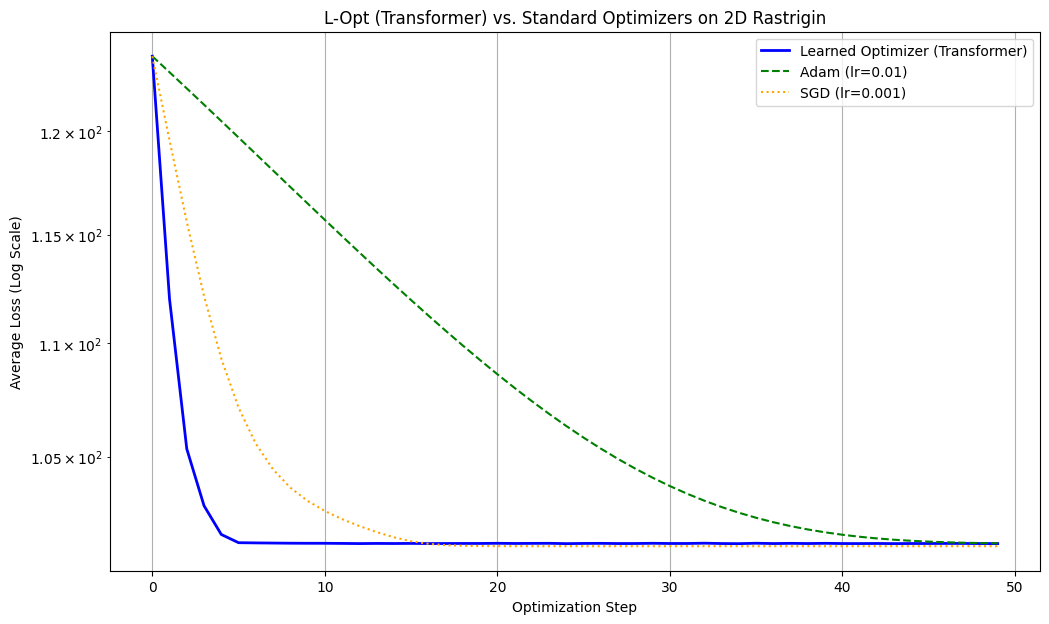

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import math


IO_DIMENSIONS = 2  
HIDDEN_SIZE = 32   
NHEAD = 4          
NUM_LAYERS = 2     
MAX_SEQ_LEN = 60   

meta_epochs = 2000
unroll_steps = 25
meta_lr = 0.001
batch_size = 128



def f(x, target):
    """Batched 2D Rastrigin function."""
    n = IO_DIMENSIONS
    x_shifted = x - target
    return (10 * n) + torch.sum(x_shifted**2 - 10 * torch.cos(2 * torch.pi * x_shifted), dim=1, keepdim=True)

def grad_f(x, target):
    """Batched 2D gradient of Rastrigin function."""
    x_shifted = x - target
    return 2 * x_shifted + 20 * torch.pi * torch.sin(2 * torch.pi * x_shifted)

# Transformer Based Learned Optimizer

class LearnedOptimizer(nn.Module):
    def __init__(self, input_size=IO_DIMENSIONS, hidden_size=HIDDEN_SIZE,
                 nhead=NHEAD, num_layers=NUM_LAYERS, max_len=MAX_SEQ_LEN):
        super(LearnedOptimizer, self).__init__()

        # Projects 2d gradient to Transformer's hidden size
        self.input_layer = nn.Linear(input_size, hidden_size)
        # Positionl encoding to give the model a sense of order
        self.pos_encoder = nn.Embedding(max_len, hidden_size)
        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_size,
            nhead=nhead,
            dim_feedforward=hidden_size * 4,
            dropout=0.1,
            batch_first=True # suggested by LLM
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )
        # Projects from the Transformer's hidden size back to a 2D update step
        self.output_layer = nn.Linear(hidden_size, input_size)

        self.max_len = max_len

    def forward(self, grad_seq):
        """
        Input: grad_seq, shape (batch_size, seq_len, IO_DIMENSIONS)
        This is the entire history of gradients up to the current step.
        """
        batch_size, seq_len, _ = grad_seq.shape

        if seq_len > self.max_len:
            raise ValueError("Sequence length exceeds max_len")

        # Gradients to hidden state size (2 to 32)
        x = self.input_layer(grad_seq)
        # Adding positional embeddings
        pos = torch.arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, -1)
        pos_emb = self.pos_encoder(pos)
        x = x + pos_emb
        # Look-Ahead Mask: We used this to ensure that the prediction the t-th can only depend on gradients from steps 0...t, not t+1.
        mask = nn.Transformer.generate_square_subsequent_mask(seq_len).to(x.device)
        # Passing through transformer
        transformer_out = self.transformer_encoder(x, mask=mask, is_causal=False) # We pass explicit mask
        # Extracting only the last output for the most recent gradient
        last_output = transformer_out[:, -1, :]
        update_step = self.output_layer(last_output)

        return update_step


lopt = LearnedOptimizer()
meta_optimizer = optim.Adam(lopt.parameters(), lr=meta_lr)

print("--- Starting Meta-Training of Learned Optimizer (Transformer) ---")
lopt.train()

for epoch in range(meta_epochs):
    targets = torch.randn(batch_size, IO_DIMENSIONS) * 5.0
    x = torch.randn(batch_size, IO_DIMENSIONS) * 5.0
    # We store the gradient history
    grad_history = []
    total_loss_for_meta_update = 0
    for t in range(unroll_steps):
        # Calculate loss and gradient
        loss = f(x, targets)
        grad = grad_f(x, targets)
        total_loss_for_meta_update += loss.mean()
        # Add current grad to history
        # We detach to prevent gradients flowing into past steps
        grad_history.append(grad.detach())
        # Stack history to seq tensor, at step t, shape is (batch, t+1, 2)
        grad_seq = torch.stack(grad_history, dim=1)
        # Getting and applying update
        update_step = lopt(grad_seq)
        x = x + update_step

    meta_optimizer.zero_grad()
    total_loss_for_meta_update.backward()
    meta_optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Avg Final Loss: {total_loss_for_meta_update.item() / unroll_steps:.6f}")

print("--- Meta-Training Finished ---")



print("\n--- Starting Evaluation (Transformer) ---")
lopt.eval()

eval_steps = 50
num_eval_problems = 100
sgd_lr = 0.001
adam_lr = 0.01

lopt_loss_history = np.zeros((num_eval_problems, eval_steps))
sgd_loss_history = np.zeros((num_eval_problems, eval_steps))
adam_loss_history = np.zeros((num_eval_problems, eval_steps))

for i in range(num_eval_problems):
    target = torch.randn(1, IO_DIMENSIONS) * 5.0
    start_x = torch.randn(1, IO_DIMENSIONS) * 5.0

    with torch.no_grad():
        x_lopt = start_x.clone()

        # History must be managed for each test problem
        grad_history_lopt = []

        for t in range(eval_steps):
            loss = f(x_lopt, target)
            lopt_loss_history[i, t] = loss.item()

            grad = grad_f(x_lopt, target)
            grad_history_lopt.append(grad)

            # Stack history just like in training
            grad_seq = torch.stack(grad_history_lopt, dim=1)

            update = lopt(grad_seq)
            x_lopt = x_lopt + update

    x_sgd = start_x.clone()
    for t in range(eval_steps):
        loss = f(x_sgd, target)
        sgd_loss_history[i, t] = loss.item()
        grad = grad_f(x_sgd, target)
        x_sgd = x_sgd - sgd_lr * grad

    x_adam = nn.Parameter(start_x.clone())
    adam_optimizer = optim.Adam([x_adam], lr=adam_lr)
    for t in range(eval_steps):
        adam_optimizer.zero_grad()
        loss = f(x_adam, target)
        adam_loss_history[i, t] = loss.item()
        loss.backward()
        adam_optimizer.step()

print("--- Evaluation Finished ---")


avg_lopt_loss = np.mean(lopt_loss_history, axis=0)
avg_sgd_loss = np.mean(sgd_loss_history, axis=0)
avg_adam_loss = np.mean(adam_loss_history, axis=0)

plt.figure(figsize=(12, 7))
plt.plot(avg_lopt_loss, label='Learned Optimizer (Transformer)', color='blue', linewidth=2)
plt.plot(avg_adam_loss, label=f'Adam (lr={adam_lr})', color='green', linestyle='--')
plt.plot(avg_sgd_loss, label=f'SGD (lr={sgd_lr})', color='orange', linestyle=':')

plt.title('L-Opt (Transformer) vs. Standard Optimizers on 2D Rastrigin')
plt.xlabel('Optimization Step')
plt.ylabel('Average Loss (Log Scale)')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print(torch.__version__)

2.9.1+cu128


# Experiments With Fine-Tuning

Running on device: cpu

--- Training Multi-Task Specialist (Rastrigin + Rosenbrock) ---
Epoch 0/500, Avg Loss: 26.9552
Epoch 100/500, Avg Loss: 6.0244
Epoch 200/500, Avg Loss: 91.8591
Epoch 300/500, Avg Loss: 5.8900
Epoch 400/500, Avg Loss: 5.5432
Meta-training finished in 28.77 seconds.
--- Multi-Task Specialist Finished. ---

--- Phase 1: Meta-Training Generalist on Quadratic Family ---
Epoch 0/500, Avg Loss: 7.9094
Epoch 100/500, Avg Loss: -3.5919
Epoch 200/500, Avg Loss: -8.3526
Epoch 300/500, Avg Loss: -6.7718
Epoch 400/500, Avg Loss: -6.9867
Meta-training finished in 33.02 seconds.
--- Phase 1 Finished. Generalist L-Opt created. ---

--- Phase 2a: Fine-tuning Generalist on Rastrigin ---
Epoch 0/250, Avg Loss: 58.1215
Epoch 100/250, Avg Loss: 12.4566
Epoch 200/250, Avg Loss: 6.0732
Meta-training finished in 13.22 seconds.

--- Phase 2b: Fine-tuning Generalist on Rosenbrock ---
Epoch 0/250, Avg Loss: 370.7089
Epoch 100/250, Avg Loss: 75.9147
Epoch 200/250, Avg Loss: 60.7159
Meta-tr

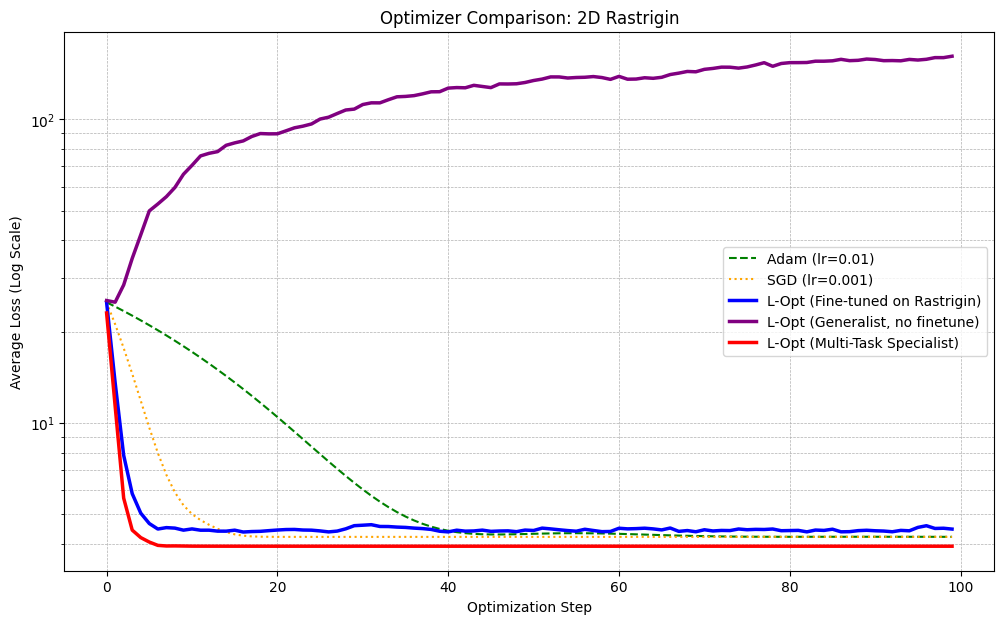

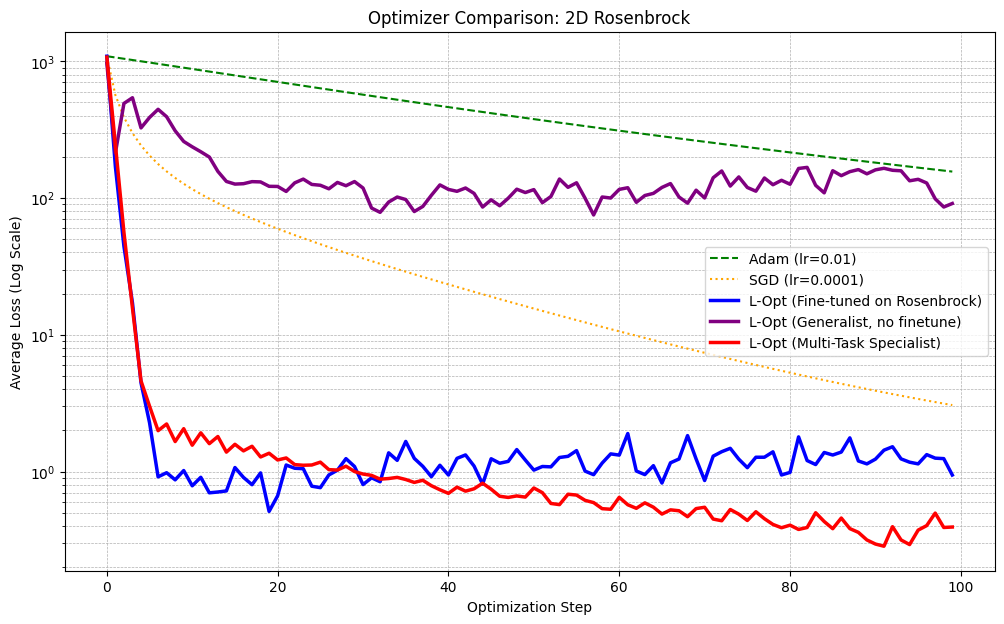

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import time
import copy


# N-Dimensional Rastrigin
def f_rastrigin(x):
    A = 10
    n = x.shape[-1]
    return A * n + torch.sum(x**2 - A * torch.cos(2 * torch.pi * x), dim=-1)
def grad_f_rastrigin(x):
    return 2 * x + 10 * 2 * torch.pi * torch.sin(2 * torch.pi * x)

def f_rastrigin_2d(x):
    return f_rastrigin(x)
def grad_f_rastrigin_2d(x):
    return grad_f_rastrigin(x)

def f_rosenbrock_2d(params):
    x = params[..., 0]
    y = params[..., 1]
    a = 1.0
    b = 100.0
    return (a - x)**2 + b * (y - x**2)**2

def grad_f_rosenbrock_2d(params):
    x = params[..., 0]
    y = params[..., 1]
    a = 1.0
    b = 100.0
    grad_x = -2.0 * (a - x) - 4.0 * b * (y - x**2) * x
    grad_y = 2.0 * b * (y - x**2)
    grad = torch.stack([grad_x, grad_y], dim=-1)
    return grad


def f_quad_family(x, A, b):
    term1 = 0.5 * torch.einsum('bi,bij,bj->b', x, A, x)
    term2 = -torch.einsum('bi,bi->b', x, b)
    return term1 + term2

def grad_f_quad_family(x, A, b):
    term1 = torch.einsum('bij,bj->bi', A, x)
    term2 = -b
    return term1 + term2

def generate_quadratic_family(batch_size, problem_dim, device):
    L = torch.randn(batch_size, problem_dim, problem_dim, device=device)
    A = L @ L.transpose(-1, -2) + 0.1 * torch.eye(problem_dim, device=device).unsqueeze(0)
    b = torch.randn(batch_size, problem_dim, device=device) * 2.0
    return f_quad_family, grad_f_quad_family, {'A': A, 'b': b}

def f_rastrigin_family(x, **kwargs):
    return f_rastrigin_2d(x)

def grad_f_rastrigin_family(x, **kwargs):
    return grad_f_rastrigin_2d(x)

def generate_rastrigin_family(batch_size, problem_dim, device):
    return f_rastrigin_family, grad_f_rastrigin_family, {}

def f_rosenbrock_family(x, **kwargs):
    return f_rosenbrock_2d(x)

def grad_f_rosenbrock_family(x, **kwargs):
    return grad_f_rosenbrock_2d(x)

def generate_rosenbrock_family(batch_size, problem_dim, device):
    return f_rosenbrock_family, grad_f_rosenbrock_family, {}

def generate_multi_specialist_family(batch_size, problem_dim, device):
    if torch.rand(1).item() < 0.5:
        return f_rastrigin_family, grad_f_rastrigin_family, {}
    else:
        return f_rosenbrock_family, grad_f_rosenbrock_2d, {} 


class LearnedOptimizerRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2):
        super(LearnedOptimizerRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.output_layer = nn.Linear(hidden_size, input_size) 

    def forward(self, grad, hc_state):
        grad_seq = grad.unsqueeze(1)
        rnn_out, next_hc_state = self.lstm(grad_seq, hc_state)
        rnn_out_flat = rnn_out.squeeze(1)
        update = self.output_layer(rnn_out_flat)
        return update, next_hc_state

    def init_state(self, batch_size, device):
        return (
            torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device),
            torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        )

def meta_train(
    lopt, problem_generator, problem_dim,
    meta_epochs=500, unroll_steps=20, batch_size=128, meta_lr=0.001,
    device='cpu'
):
    lopt.to(device)
    meta_optimizer = optim.Adam(lopt.parameters(), lr=meta_lr)

    start_time = time.time()
    for epoch in range(meta_epochs):
        lopt.train()
        meta_optimizer.zero_grad()

        f_batch, grad_f_batch, params_batch = problem_generator(
            batch_size, problem_dim, device
        )

        x_t = (torch.rand(batch_size, problem_dim, device=device) - 0.5) * 5.0
        x_t.requires_grad = True

        hc_t = lopt.init_state(batch_size, device=device)

        total_loss = 0.0
        for t in range(unroll_steps):
            loss_t = f_batch(x_t, **params_batch).mean()
            # LLM helped us fix a bug here: 
            # Detach g_t after computing it. This ensures that the L-Opt's
            # gradients are computed with respect to the loss, but the L-Opt
            # itself doesn't try to backpropagate through the problem function
            #'s parameters. This is standard practice in L2L.
            g_t = grad_f_batch(x_t, **params_batch)
            g_t_detached = g_t.detach() # Detach here

            hc_t = (hc_t[0].detach(), hc_t[1].detach())
            update_t, hc_t = lopt(g_t_detached, hc_t) # Use detached gradient here

            x_t = x_t - update_t
            total_loss = total_loss + loss_t

        total_loss.backward()
        nn.utils.clip_grad_norm_(lopt.parameters(), 1.0)
        meta_optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch}/{meta_epochs}, Avg Loss: {total_loss.item() / unroll_steps:.4f}")

    end_time = time.time()
    print(f"Meta-training finished in {end_time - start_time:.2f} seconds.")
    return lopt

def meta_evaluate(
    lopt, f, grad_f, problem_dim,
    eval_steps=100, num_problems=100,
    sgd_lr=0.01, adam_lr=0.01,
    noise_level=0.0, device='cpu'
):
    lopt.to(device)
    lopt.eval()

    loss_history_lopt = np.zeros((num_problems, eval_steps))
    loss_history_sgd = np.zeros((num_problems, eval_steps))
    loss_history_adam = np.zeros((num_problems, eval_steps))

    for i in range(num_problems):
        x_init = (torch.rand(1, problem_dim, device=device) - 0.5) * 5.0

        with torch.no_grad():
            x_lopt = x_init.clone()
            hc_t = lopt.init_state(batch_size=1, device=device)
            for t in range(eval_steps):
                loss_history_lopt[i, t] = f(x_lopt).item()
                g = grad_f(x_lopt)
                g_noisy = g + torch.randn_like(g) * noise_level
                update, hc_t = lopt(g_noisy, hc_t)
                x_lopt = x_lopt - update

        x_sgd = x_init.clone().requires_grad_()
        optimizer_sgd = optim.SGD([x_sgd], lr=sgd_lr)
        for t in range(eval_steps):
            loss_history_sgd[i, t] = f(x_sgd).item()
            optimizer_sgd.zero_grad()
            loss_t = f(x_sgd)
            loss_t.backward()
            if noise_level > 0: x_sgd.grad += torch.randn_like(x_sgd.grad) * noise_level
            optimizer_sgd.step()

        x_adam = x_init.clone().requires_grad_()
        optimizer_adam = optim.Adam([x_adam], lr=adam_lr)
        for t in range(eval_steps):
            loss_history_adam[i, t] = f(x_adam).item()
            optimizer_adam.zero_grad()
            loss_t = f(x_adam)
            loss_t.backward()
            if noise_level > 0: x_adam.grad += torch.randn_like(x_adam.grad) * noise_level
            optimizer_adam.step()

    return (
        np.mean(loss_history_lopt, axis=0),
        np.mean(loss_history_sgd, axis=0),
        np.mean(loss_history_adam, axis=0)
    )



def plot_results(results_list, title="Optimizer Comparison", yscale='log'):
    """
    results_list should be a tuple:
    (avg_lopt, avg_sgd, avg_adam, "L-Opt Label", sgd_lr, adam_lr)
    """
    plt.figure(figsize=(12, 7))

    if results_list:
        _, avg_sgd, avg_adam, _, sgd_lr, adam_lr = results_list[0]
        plt.plot(avg_adam, label=f'Adam (lr={adam_lr})', color='green', linestyle='--')
        plt.plot(avg_sgd, label=f'SGD (lr={sgd_lr})', color='orange', linestyle=':')

    colors = {
        'Fine-tuned': 'blue',
        'Generalist': 'purple',
        'Multi-Task': 'red'
    }

    for (avg_lopt, _, _, label, _, _) in results_list:
        color_key = '' 
        if 'Generalist' in label:
            color_key = 'Generalist'
        elif 'Multi-Task' in label:
            color_key = 'Multi-Task'
        elif 'Fine-tuned' in label:
            color_key = 'Fine-tuned'

        if color_key not in colors:
            print(f"Warning: '{color_key}' is not a recognized color key. Using default 'Fine-tuned'.")
            color_key = 'Fine-tuned'

        plt.plot(avg_lopt, label=label, color=colors[color_key], linewidth=2.5)

    plt.title(title)
    plt.xlabel('Optimization Step')
    plt.ylabel('Average Loss' + (' (Log Scale)' if yscale == 'log' else ''))
    if yscale == 'log':
        plt.yscale('log')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()



if __name__ == "__main__":
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    IO_DIMENSIONS = 2
    HIDDEN_SIZE = 32
    NUM_LAYERS = 2

    SGD_LR_RASTRIGIN = 0.001
    ADAM_LR_RASTRIGIN = 0.01
    SGD_LR_ROSENBROCK = 0.0001
    ADAM_LR_ROSENBROCK = 0.01

    print(f"Running on device: {DEVICE}")

 
    print("\n--- Training Multi-Task Specialist (Rastrigin + Rosenbrock) ---")
    lopt_multi_specialist = LearnedOptimizerRNN(
        IO_DIMENSIONS, HIDDEN_SIZE, NUM_LAYERS
    ).to(DEVICE)

    lopt_multi_specialist = meta_train(
        lopt=lopt_multi_specialist,
        problem_generator=generate_multi_specialist_family, 
        problem_dim=IO_DIMENSIONS,
        meta_epochs=500, 
        unroll_steps=20,
        batch_size=128,
        meta_lr=0.001,
        device=DEVICE
    )
    print("--- Multi-Task Specialist Finished. ---")

    # --- Phase 1: Meta-Training Generalist on Quadratic Family ---
    print("\n--- Phase 1: Meta-Training Generalist on Quadratic Family ---")
    lopt_generalist = LearnedOptimizerRNN(
        IO_DIMENSIONS, HIDDEN_SIZE, NUM_LAYERS
    ).to(DEVICE)

    lopt_generalist = meta_train(
        lopt=lopt_generalist,
        problem_generator=generate_quadratic_family,
        problem_dim=IO_DIMENSIONS,
        meta_epochs=500,
        unroll_steps=20,
        batch_size=128,
        meta_lr=0.001,
        device=DEVICE
    )
    print("--- Phase 1 Finished. Generalist L-Opt created. ---")


    print("\n--- Phase 2a: Fine-tuning Generalist on Rastrigin ---")
    lopt_ft_rastrigin = copy.deepcopy(lopt_generalist)
    lopt_ft_rastrigin = meta_train(
        lopt=lopt_ft_rastrigin,
        problem_generator=generate_rastrigin_family,
        problem_dim=IO_DIMENSIONS,
        meta_epochs=250,
        unroll_steps=20,
        batch_size=128,
        meta_lr=0.0005,
        device=DEVICE
    )

    print("\n--- Phase 2b: Fine-tuning Generalist on Rosenbrock ---")
    lopt_ft_rosenbrock = copy.deepcopy(lopt_generalist)
    lopt_ft_rosenbrock = meta_train(
        lopt=lopt_ft_rosenbrock,
        problem_generator=generate_rosenbrock_family,
        problem_dim=IO_DIMENSIONS,
        meta_epochs=250,
        unroll_steps=20,
        batch_size=128,
        meta_lr=0.0005,
        device=DEVICE
    )
    print("--- Phase 2 Finished. Fine-tuned optimizers created. ---")

    print("--- Phase 3: Evaluating Optimizers ---")

    # Evaluate on Rastrigin
    print("Evaluating on 2D Rastrigin...")
    lopt_rastrigin, sgd_rastrigin, adam_rastrigin = meta_evaluate(
        lopt_ft_rastrigin,
        f_rastrigin_2d, grad_f_rastrigin_2d,
        problem_dim=IO_DIMENSIONS, eval_steps=100,
        sgd_lr=SGD_LR_RASTRIGIN, adam_lr=ADAM_LR_RASTRIGIN,
        device=DEVICE
    )

    lopt_general_on_rastrigin, _, _ = meta_evaluate(
        lopt_generalist,
        f_rastrigin_2d, grad_f_rastrigin_2d,
        problem_dim=IO_DIMENSIONS, eval_steps=100,
        sgd_lr=SGD_LR_RASTRIGIN, adam_lr=ADAM_LR_RASTRIGIN,
        device=DEVICE
    )

    lopt_multi_on_rastrigin, _, _ = meta_evaluate(
        lopt_multi_specialist,
        f_rastrigin_2d, grad_f_rastrigin_2d,
        problem_dim=IO_DIMENSIONS, eval_steps=100,
        sgd_lr=SGD_LR_RASTRIGIN, adam_lr=ADAM_LR_RASTRIGIN,
        device=DEVICE
    )

    # Evaluate on Rosenbrock
    print("Evaluating on 2D Rosenbrock...")
    lopt_rosenbrock, sgd_rosenbrock, adam_rosenbrock = meta_evaluate(
        lopt_ft_rosenbrock,
        f_rosenbrock_2d, grad_f_rosenbrock_2d,
        problem_dim=IO_DIMENSIONS, eval_steps=100,
        sgd_lr=SGD_LR_ROSENBROCK, adam_lr=ADAM_LR_ROSENBROCK,
        device=DEVICE
    )

    lopt_general_on_rosenbrock, _, _ = meta_evaluate(
        lopt_generalist,
        f_rosenbrock_2d, grad_f_rosenbrock_2d,
        problem_dim=IO_DIMENSIONS, eval_steps=100,
        sgd_lr=SGD_LR_ROSENBROCK, adam_lr=ADAM_LR_ROSENBROCK,
        device=DEVICE
    )

    lopt_multi_on_rosenbrock, _, _ = meta_evaluate(
        lopt_multi_specialist,
        f_rosenbrock_2d, grad_f_rosenbrock_2d,
        problem_dim=IO_DIMENSIONS, eval_steps=100,
        sgd_lr=SGD_LR_ROSENBROCK, adam_lr=ADAM_LR_ROSENBROCK,
        device=DEVICE
    )
    print("--- Evaluation Finished. ---")

    print("\n--- Phase 4: Plotting Results ---")

    # Plot Rastrigin Results
    plot_results(
        [
            (lopt_rastrigin, sgd_rastrigin, adam_rastrigin,
             "L-Opt (Fine-tuned on Rastrigin)", SGD_LR_RASTRIGIN, ADAM_LR_RASTRIGIN),

            (lopt_general_on_rastrigin, sgd_rastrigin, adam_rastrigin,
             "L-Opt (Generalist, no finetune)", SGD_LR_RASTRIGIN, ADAM_LR_RASTRIGIN),

            (lopt_multi_on_rastrigin, sgd_rastrigin, adam_rastrigin,
             "L-Opt (Multi-Task Specialist)", SGD_LR_RASTRIGIN, ADAM_LR_RASTRIGIN)
        ],
        title="Optimizer Comparison: 2D Rastrigin"
    )

    # Plot Rosenbrock Results
    plot_results(
        [
            (lopt_rosenbrock, sgd_rosenbrock, adam_rosenbrock,
             "L-Opt (Fine-tuned on Rosenbrock)", SGD_LR_ROSENBROCK, ADAM_LR_ROSENBROCK),

            (lopt_general_on_rosenbrock, sgd_rosenbrock, adam_rosenbrock,
             "L-Opt (Generalist, no finetune)", SGD_LR_ROSENBROCK, ADAM_LR_ROSENBROCK),

            (lopt_multi_on_rosenbrock, sgd_rosenbrock, adam_rosenbrock,
             "L-Opt (Multi-Task Specialist)", SGD_LR_ROSENBROCK, ADAM_LR_ROSENBROCK)
        ],
        title="Optimizer Comparison: 2D Rosenbrock"
    )
